### **1. Importing data to work on from kaggle and the important Python packages.**

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download kazanova/sentiment140

100% 80.9M/80.9M [00:02<00:00, 44.2MB/s]
100% 80.9M/80.9M [00:02<00:00, 31.7MB/s]


In [6]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
import pandas as pd
cols = ['target','id','date','flag','user','text']
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1' ,names=cols)

In [8]:
# Preprocessing packages
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

### **2. Understanding the data** ###

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['target'].value_counts

<bound method IndexOpsMixin.value_counts of 0          0
1          0
2          0
3          0
4          0
          ..
1599995    4
1599996    4
1599997    4
1599998    4
1599999    4
Name: target, Length: 1600000, dtype: int64>

In [ ]:
df = df[['text','target']]
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


In [ ]:
df.describe()

,target
count,1.600000e+06
mean,2.000000e+00
std,2.000001e+00
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,4.000000e+00


In [ ]:
df['target'].unique()

array([0, 4])

So, there are two unique values 0 and 4. Now, let's find out which one is positive sentiment and whih one is negative sentiment. From the df above, we can see that the first few texts are having a sentiment 0 while the last few has 4.

In [ ]:
df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [ ]:
df.tail()

,text,target
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,4


So, it looks like 0 targets negative sentiment, while 4 targets positive sentiment.

Now, let's see whether the dataset is balanced or not.

([<matplotlib.axis.XTick at 0x7fdb2d0e3a50>,
 [Text(0, 0, 'Negative'), Text(0, 0, 'Positive')])

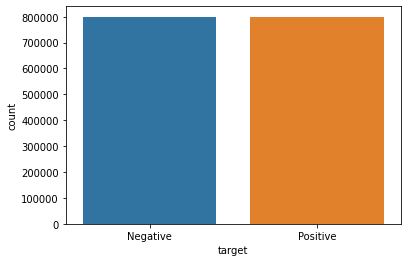

In [ ]:
sns.countplot(data=df,x='target')
plt.xticks(ticks=[0,1],labels=['Negative','Positive'])

Okay, the dataset is very well balanced. Let's go to the next step.

In [ ]:
for item in df.text:
  if item == ':)' or item == ':(':
    print('Found emoticon')
    break

### **3. Text preprocessing** ###

Dataset before preprocessing

In [ ]:
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


In [ ]:
def clean_text(text):
    """
    Data Preprocessing is done here.
    """

    # Step 1 -  Lowering the cases
    text = text.lower()

    # Step 2 - remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", "URL",text,flags = re.MULTILINE)

    # Step 3 - remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Step 4 - remove @ and #
    text = re.sub(r'\@',"USER",text)
    text = re.sub(r'\#', "", text)

    # Step 5 - remove extra charaters in each word (more than 2 continuous ones)
    repeat_char = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    text = repeat_char.sub(r"\1\1", text)
    text = re.sub("(.)\\1{2,}", "\\1", text)

    # Step 6 - remove tokens
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords]

    # Step 7 - Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in tokens]
        
    return " ".join(lemma_words)

df['text'] = [clean_text(text) for text in df['text']]

Dataset after text preprocessing...

In [ ]:
df.head()

,text,target
0,switchfoot URL aURL thats bummer shoulda got d...,0
1,upset cant update facebook texting might cry r...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass behaving im mad cant see,0


In [ ]:
df.to_csv('cleaned_data.csv')

### **4. Preparing the data for the model**###

In [ ]:
df = pd.read_csv('cleaned_data.csv')

In [ ]:
df.dropna(inplace=True)
df.count()

Unnamed: 0    1599674
text          1599674
target        1599674
dtype: int64

In [ ]:
df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Length: 1599674, dtype: bool

In [ ]:
df.drop_duplicates(inplace=True)
df.count()

Unnamed: 0    1599674
text          1599674
target        1599674
dtype: int64

In [ ]:
x = df['text']
y = df['target']

In [ ]:
# Preprocessing packages
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
x.count()

1599674

In [ ]:
y #Before changing values

0          0
1          0
2          0
3          0
4          0
          ..
1599995    4
1599996    4
1599997    4
1599998    4
1599999    4
Name: target, Length: 1599674, dtype: int64

In [ ]:
y = np.asarray(y)

Now, we do a small tweak. Since we are doing classification, we are changing target 4 to 1, to make things simpler.

In [ ]:
import numpy as np
y = np.where(y==4,1,y)
y = np.asarray(y)
y #After changing values

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
num_classes = 2
y = to_categorical(y, num_classes)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15 ,random_state = 1)

In [ ]:
tokenizer = Tokenizer(num_words=5000) #num_words says the number of top frequent words
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
word_index = tokenizer.word_index

In [ ]:
# Checking first 5 text sequences
print('Sequence 0:',sequences[0])
print('Sequence 1:',sequences[1])
print('Sequence 2:',sequences[2])
print('Sequence 3:',sequences[3])
print('Sequence 4:',sequences[4])

Sequence 0: [1, 768, 1615, 922]
Sequence 1: [562, 356, 431, 123, 137, 54, 3427, 95, 1172, 134, 74]
Sequence 2: [9, 48, 3725, 2146, 1, 1615, 2265, 42]
Sequence 3: [466, 623, 2139, 257, 64, 321, 2059]
Sequence 4: [16, 820, 157, 1674, 170, 25, 223, 42]


In [ ]:
#Check input length...should be in same size
max = 0
for i in range(len(sequences)):
  word_number = len(sequences[i])
  if (word_number) > (max):
    max = word_number
print(max)

34


In [ ]:
#Padding shorter sequences
x_train = pad_sequences(sequences, padding = 'post', maxlen = max)

print(x_train[:1])
print(x_train[1:2])
print(x_train[2:3])
print(x_train[3:4])
print(x_train[4:5])

[[   1  768 1615  922    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[ 562  356  431  123  137   54 3427   95 1172  134   74    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[   9   48 3725 2146    1 1615 2265   42    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[ 466  623 2139  257   64  321 2059    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[  16  820  157 1674  170   25  223   42    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [ ]:
x_train.shape

(1359722, 34)

In [ ]:
y_train.shape

(1359722, 2)

In [ ]:
y_test.shape

(239952, 2)

In [ ]:
x_test.shape

(239952,)

### **5. Preparing the model** ###

In [ ]:
#Creating model
model = Sequential()
model.add(Embedding(5000, 400, input_length = x_train.shape[1]))
model.add(LSTM(200, return_sequences=True, recurrent_dropout=0.25))
model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.25))
model.add(LSTM(50, recurrent_dropout=0.25))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 34, 400)           2000000   
                                                                 
 lstm_6 (LSTM)               (None, 34, 200)           480800    
                                                                 
 lstm_7 (LSTM)               (None, 34, 100)           120400    
                                                                 
 lstm_8 (LSTM)               (None, 50)                30200     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,631,502
Trainable params: 2,631,502
Non-trainable params: 0
_________________________________________________________________


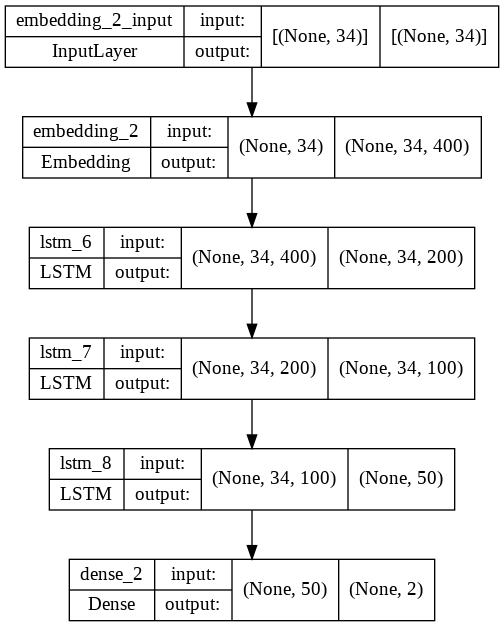

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
y_test.shape

(239952, 2)

In [ ]:
x_test_dummy = tokenizer.texts_to_sequences(x_test)
x_test_dummy = np.array(x_test_dummy)
x_test_dummy = pad_sequences(x_test_dummy,padding='post',maxlen=max)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import EarlyStopping
# callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
#              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
# training model
history = model.fit(x_train,y_train, epochs=5, batch_size=10000, verbose=1, validation_data = (x_test_dummy,y_test))

Epoch 1/5
136/136 [==============================] - 139s 949ms/step - loss: 0.6104 - accuracy: 0.6369 - val_loss: 0.4884 - val_accuracy: 0.7705
Epoch 2/5
136/136 [==============================] - 127s 937ms/step - loss: 0.4805 - accuracy: 0.7731 - val_loss: 0.4737 - val_accuracy: 0.7756
Epoch 3/5
136/136 [==============================] - 127s 936ms/step - loss: 0.4730 - accuracy: 0.7759 - val_loss: 0.4712 - val_accuracy: 0.7768
Epoch 4/5
136/136 [==============================] - 127s 933ms/step - loss: 0.4705 - accuracy: 0.7771 - val_loss: 0.4687 - val_accuracy: 0.7778
Epoch 5/5
136/136 [==============================] - 127s 936ms/step - loss: 0.4691 - accuracy: 0.7779 - val_loss: 0.4677 - val_accuracy: 0.7780


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


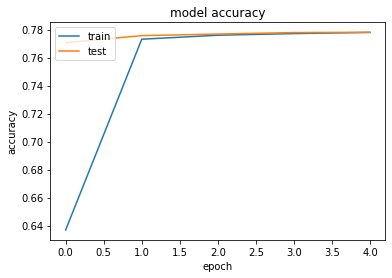

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

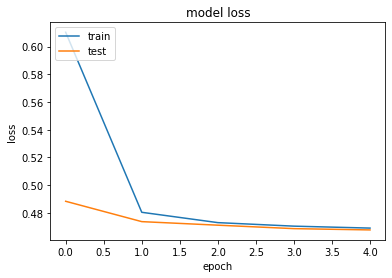

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model2 = model
loss, accuracy = model2.evaluate(x_test_dummy, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

7499/7499 [==============================] - 221s 29ms/step - loss: 0.4677 - accuracy: 0.7780
Loss: 0.4677445590496063
Accuracy: 0.7780430912971497


### **6. Predicting sentences** ###

In [ ]:
a = ['i love it']
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a,padding='post',maxlen=max)
print(a)
print(a.shape)
prediction = model.predict(np.array(a))
print(prediction[0][0].round(), prediction[0][1].round())

[[12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]]
(1, 34)
0.0 1.0


In [ ]:
b = ['i hate it']
b = tokenizer.texts_to_sequences(b)
b = np.array(b)
b = pad_sequences(b,padding='post',maxlen=max)
print(b)
print(b.shape)
prediction = model.predict(np.array(b))
print(prediction[0][0].round(), prediction[0][1].round())

[[78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0]]
(1, 34)
1.0 0.0


In [ ]:
b = ['i ate it with great pleasure']
b = tokenizer.texts_to_sequences(b)
b = np.array(b)
b = pad_sequences(b,padding='post',maxlen=max)
print(b)
print(b.shape)
prediction = model.predict(np.array(b))
print(prediction[0][0].round(), prediction[0][1].round())

[[ 589   39 1541    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
(1, 34)
0.0 1.0


In [ ]:
b = ['This sofa is very uncomfortable']
b = tokenizer.texts_to_sequences(b)
b = np.array(b)
b = pad_sequences(b,padding='post',maxlen=max)
print(b)
print(b.shape)
prediction = model.predict(np.array(b))
print(prediction[0][0].round(), prediction[0][1].round())

[[3535 4385    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
(1, 34)
1.0 0.0


### **7. Exporting model** ###

In [ ]:
model.save('Sentiment_analysis_LSTM.h5')

### **8. Model Indormation** ###

In [ ]:
x_test_dummy = tokenizer.texts_to_sequences(x_test)
x_test_dummy = np.array(x_test_dummy)
x_test_dummy = pad_sequences(x_test_dummy,padding='post',maxlen=max)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Predict probabilities for test set
yhat_probs = model.predict(x_test_dummy, verbose=0)
yhat_probs

array([[0.2844669 , 0.71239746],
       [0.44644725, 0.5535763 ],
       [0.08782396, 0.9132711 ],
       ...,
       [0.7120421 , 0.29053146],
       [0.1834139 , 0.8150087 ],
       [0.95878047, 0.03959624]], dtype=float32)

In [ ]:
yhat_classes = yhat_probs.round().astype(int)
yhat_classes

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [ ]:
yhat_test = y_test

In [ ]:
# Reduce to 1d array
yhat_test = yhat_test[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
# Accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(yhat_test, yhat_classes)
print('Accuracy: %f' % accuracy)

# Precision tp / (tp + fp)
precision = precision_score(yhat_test, yhat_classes)
print('Precision: %f' % precision)

# Recall: tp / (tp + fn)
recall = recall_score(yhat_test, yhat_classes)
print('Recall: %f' % recall)

# F1 Score: 2 tp / (2 tp + fp + fn)
f1 = f1_score(yhat_test, yhat_classes)
print('F1 score: %f' % f1)

# Confusion matrix
matrix = confusion_matrix(yhat_test, yhat_classes)
print(matrix)

Accuracy: 0.778022
Precision: 0.787042
Recall: 0.761777
F1 score: 0.774204
[[95373 24708]
 [28556 91315]]


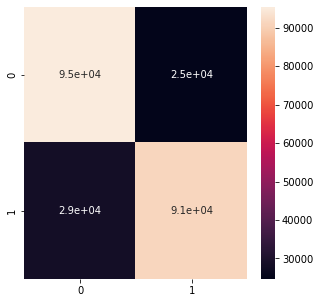

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True)